# M31 2015 Luminous Red Nova, basic theoretical arguments

### Tassos Fragkos & Jeff J. Andrews

In this notebook, we are loading the static stellar profile of a 5.5 Msun subgiant. We will demonstrate, using this stellar profile, how energy is released over time as a companion spirals inside. Importantly, our results will indicate that the majority of the gravitational energy from the merger will be released near the core of the subgiant, and that it will take of order days for that energy to reach the stellar surface (based on the acoustic depth). This calculate justifies a more self-consistent approach involving the simultaneous modeling of the stellar structure as the companion star inspirals.

In [287]:
# modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint

%matplotlib inline

In [231]:
# constants in cgs
Gconst = 6.674e-8
Msun = 1.989e33
Rsun = 6.957e10
secday = 3600.0*24.0

### Load data and interpolate important variables

In [378]:
data_dir = '../data/'

# 5.5 Msun subgiant
file_dir = data_dir + 'M31_2015_LNR_5.5M_40R_tau1.data.new'
star = np.genfromtxt(file_dir, skip_header=5, names=True)

star_m_encl = interp1d(star['radius']*Rsun, star['mass']*Msun)
star_log10_rho = interp1d(star['radius']*Rsun, star['logRho'])
star_pressure_scale_height = interp1d(star['radius']*Rsun, star['pressure_scale_height']*Rsun)

# Create interpolation for dM_dr
dM_dr = star["dm"]/star["dr"]
star_dM_dr = interp1d(star['radius']*Rsun, dM_dr)
# dM_dr = np.zeros(len(star))
# i_max = len(star)-1
# for i in np.arange(i_max):
#     dM_dr[i] = (star["mass"][i] - star["mass"][i+1]) * Msun/((star["radius"][i] - star["radius"][i+1])*Rsun)
# dM_dr[i_max] = star["mass"][i_max] * Msun / (star["radius"][i_max] * Rsun)
# star_dM_dr = interp1d(star['radius'] * Rsun, dM_dr)


In [379]:
# Test plots

r_test = np.linspace(min(star["radius"])*Rsun, max(star["radius"])*Rsun, 1000)

# Test plot for dM_dr
#dM_dr_test = star_dM_dr(r_test)
#plt.plot(r_test, dM_dr_test)
#plt.plot(r_test, star_dM_dr_1(r_test))
#plt.plot(r_test, (dM_dr_test - star_dM_dr_1(r_test))/star_dM_dr_1(r_test))
#plt.xlim(0, max(r_test))
#plt.ylim(0, 7e21)

# Test plot for pressure scale height
# Hp = star_pressure_scale_height(r_test)
# plt.plot(r_test, Hp)

# Test plot for density plot
# rho = 10**star_log10_rho(r_test)
# plt.plot(r_test,rho)
# plt.yscale('log')

# Test plot for mass
# mass = star_m_encl(r_test)
# plt.plot(r_test, mass)

#plt.show()

### Keplerian velocity function

In [128]:
def get_keplerian_velocity(M_enclosed, M_companion, a_separation):
    """ Provides the keplerian velocity (circular orbit)
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    v_orb : float
        circular orbital velocity (km/s)
    """
    
    v_squared = Gconst * (M_enclosed + M_companion) * Msun / (a_separation * Rsun)
    v_orb = np.sqrt(v_squared) / 1.0e5 # converted from cm/s to km/s
    
    return v_orb

### Gravitational potential

In [129]:
def get_E_grav(M_enclosed, M_companion, a_separation):
    """ Provides the gravitational potential energy
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    E_grav : float
        gravitational potential energy (erg)
    """

    E_grav = -Gconst * (M_enclosed*Msun) * (M_companion*Msun) / (a_separation*Rsun)
    
    return E_grav

### Orbital period

In [230]:
def get_P_orb(M_enclosed, M_companion, a_separation):
    """ Provides the orbital period
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    P_orb : float
        Orbital period (s)
    """

    vel = get_keplerian_velocity(M_enclosed, M_companion, a_separation) * 1.0e5 # velocity in cm/s
    circumference = 2.0 * np.pi * a_separation*Rsun
    
    P_orb = circumference / vel
    
    return P_orb

### Define the frictional drag force from MacLeod & Ramirez-Ruiz (2015)

In [243]:
def get_F_drag(mass_in, vel_in, rho, scale_height):
    """ Provides the drag force from an inspiraling object
    
    Arguments
    ---------
    mass_in : float
        Companion mass (Msun)
    vel_in : float
        Companion velocity - assumed to be the Keplerian orbital (km/s)
    rho : float
        Local density (g/cm^3)
    scale_height : float
        Local pressure scale height (cm)
        
    Returns
    -------
    F_drag : float
        Drag force on the inspiraling companion (erg/s)
    """
    
    # Convert units to cgs
    mass = mass_in * Msun # Msun to g
    vel = vel_in * 1.0e5 # km/s to cm/s
        
    # Accretion radius
    R_accretion = 2.0 * Gconst * mass / vel**2
    
    # ratio of accretion radius to scale height
    eta = R_accretion / scale_height

    # Hoyle-Littleton drag
    F_drag_HL = np.pi * R_accretion**2 * rho * vel**2
    
    # Factor to adjust Hoyle-Littleton drag to MacLeod & Ramirez-Ruiz (2015) simulations
    f_factor = 1.91791946 + -1.52814698*eta + 0.75992092*eta**2
        
    # Drag force
    F_drag = F_drag_HL * f_factor
    
    return F_drag

### Plot enclosed mass, keplerian velocity as a function of radius

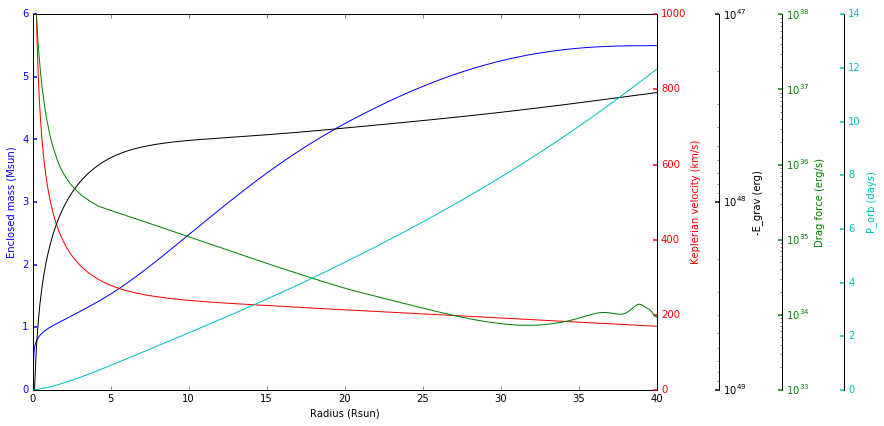

In [380]:
plt.rcParams['figure.figsize'] = 12, 6

# set companion mass
M_companion = 0.5

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# Allow space on right side for multiple y-axes
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

# Keplerian velocity y-axis
par1 = host.twinx()
# Gravitational energy y-axis
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)
# Drag force y-axis
par3 = host.twinx()
par3.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(par3)
par3.spines["right"].set_visible(True)
# P_orb y-axis
par4 = host.twinx()
par4.spines["right"].set_position(("axes", 1.3))
make_patch_spines_invisible(par4)
par4.spines["right"].set_visible(True)


# Set x-axis
x = star["radius"]
host.set_xlabel('Radius (Rsun)')
host.set_xlim(0.0, 40.0)

# Create plotted functions
M_encl, = host.plot(x, star["mass"], label="Enclosed mass", color='b')
v_kep, = par1.plot(x, get_keplerian_velocity(star["mass"],M_companion,star["radius"]), label="Keplerian velocity", color='r')
E_grav, = par2.plot(x, -get_E_grav(star["mass"],M_companion,star["radius"]), label="Gravitational energy", color='k')
# Drag force
velocity = get_keplerian_velocity(star["mass"],M_companion,star["radius"])
rho = 10**star["logRho"]
scale_height = star["pressure_scale_height"] * Rsun
F_drag, = par3.plot(x, get_F_drag(M_companion, velocity, rho, scale_height), label="Drag force", color='g')
# P_orb
P_orb, = par4.plot(x, get_P_orb(star["mass"],M_companion,star["radius"])/secday, label="P_orb", color='c')

# Set the y-axis labels
host.set_ylabel('Enclosed mass (Msun)')
par1.set_ylabel('Keplerian velocity (km/s)')
par2.set_ylabel('-E_grav (erg)')
par3.set_ylabel('Drag force (erg/s)')
par4.set_ylabel('P_orb (days)')

# Set the y-axis colors
host.yaxis.label.set_color(M_encl.get_color())
par1.yaxis.label.set_color(v_kep.get_color())
par2.yaxis.label.set_color(E_grav.get_color())
par3.yaxis.label.set_color(F_drag.get_color())
par4.yaxis.label.set_color(P_orb.get_color())

# Set the y-axis tick parameters
tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=M_encl.get_color(), **tkw)
par1.tick_params(axis='y', colors=v_kep.get_color(), **tkw)
par2.tick_params(axis='y', colors=E_grav.get_color(), **tkw)
par3.tick_params(axis='y', colors=F_drag.get_color(), **tkw)
par4.tick_params(axis='y', colors=P_orb.get_color(), **tkw)

# Set the y-axis limits
par1.set_ylim(0.0, 1000.0)
par2.set_yscale('log')
par2.set_ylim(1e49, 1e47)
par3.set_yscale('log')
par3.set_ylim(1e33, 1e38)

plt.tight_layout()

plt.show()

### Now, let's define derivatives for the inspiral over the static stellar profile

In [381]:
def get_dE_dr(E_in, r_in, M_companion):
    """ Calculates the energy dissipation rate with respect to radius
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
        
    Returns
    -------
    dE_dr : float
        The derivative of radius with respect to radius (erg/cm)    
    """
    
    # Calculate dE_dr
    m_encl = star_m_encl(r_in)
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)

    return dE_dr



    
def get_dE_dt(E_in, r_in, M_companion):
    """ Calculates the energy dissipation rate
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
        
    Returns
    -------
    dE_dt : float
        The derivative of radius with respect to time (erg/s)    
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)

    return dE_dt


    

def get_dr_dt(r_in, t_in, M_companion):
    """ Calculates the inspiral time of the star
    
    Arguments
    ---------
    r_in : float
        The radius in question (cm)
    r_in : float
        Latent variable for derivative
    M_companion : float
        The companion mass to the star (Msun)
        
    Returns
    -------
    dr_dt : float
        The derivative of radius with respect to time (cm/s)
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)
    
    # Calculate dE_dr
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)
    
    # dr_dt
    dr_dt = dE_dt / dE_dr
        
    return dr_dt
    

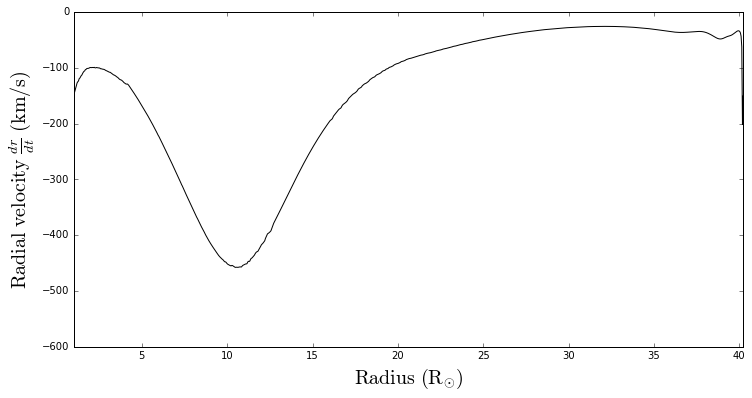

In [402]:
plt.figure(figsize=(12,6))

r_test = np.linspace(min(star["radius"])*Rsun, max(star["radius"])*Rsun, 1000)
time = 0.0

plt.plot(r_test/Rsun, get_dr_dt(r_test, time, M_companion) / 1.0e5, color='k')
plt.xlim(1, max(r_test/Rsun))
plt.ylim(-6e2, 0.0)

plt.xlabel(r'${\rm Radius}\ ({\rm R}_{\odot})$', size=20)
plt.ylabel(r'${\rm Radial\ velocity}\ \frac{dr}{dt}\ {\rm (km/s)}$',size=20)

plt.show()

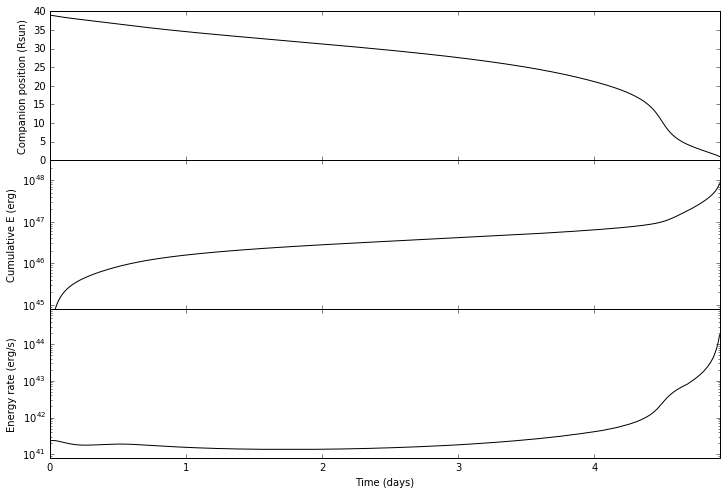

In [385]:
fig, ax = plt.subplots(3, figsize=(12,8), sharex=True)

tmin, tmax = 0.0, 4.25e5

# Radius evolution
r0 = 39.0*Rsun
t = []
t = np.linspace(tmin, tmax, 1000)
#t = np.linspace(0.0, 1.0e5, 100)
r_sol = odeint(get_dr_dt, r0, t, args=(M_companion,))
ax[0].plot(t/secday, r_sol/Rsun, color='k')
ax[0].set_ylabel('Companion position (Rsun)')

# Energy
# use the results of the previous integration to get "r_sol" corresponding to x-axis "t"
E0 = 0.0
E_sol = odeint(get_dE_dr, E0, r_sol.T[0], args=(M_companion,))
ax[1].plot(t/secday, -E_sol, color='k')
ax[1].set_yscale('log')
ax[1].set_xlim(tmin/secday, tmax/secday)
ax[1].set_ylim(8e44,3.0e48)
ax[1].set_ylabel('Cumulative E (erg)')


# Energy Dissipation
ax[2].plot(t/secday, -get_dE_dt(0.0, r_sol.T[0], M_companion), color='k')
ax[2].set_ylabel('Energy rate (erg/s)')
ax[2].set_yscale('log')
ax[2].set_ylim(8e40, 9e44)

ax[2].set_xlabel('Time (days)')


fig.subplots_adjust(hspace=0)

plt.show()

### Now, let's show how fast it takes for energy to reach the surface

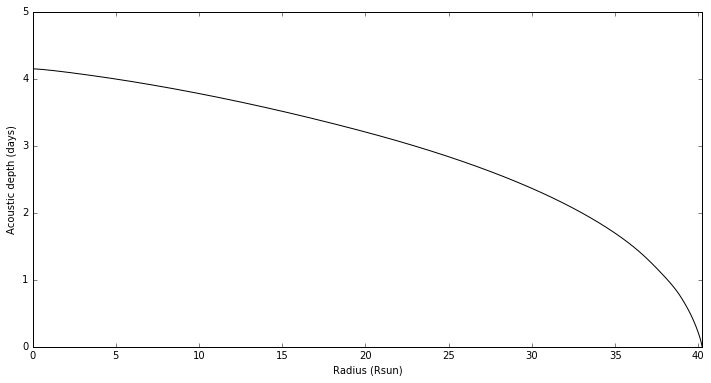

In [398]:
t_thermal = 10**star['log_thermal_time_to_surface']
t_dynamical = 10**star['log_acoustic_depth']

#plt.plot(star['radius'], t_thermal/secday)
plt.plot(star['radius'], t_dynamical/secday, color='k')

plt.xlim(0.0, max(star['radius']))
plt.ylim(0.0, 5.0)

plt.ylabel('Acoustic depth (days)')
plt.xlabel('Radius (Rsun)')

plt.show()